In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from utils import *
import numpy as np 

mu0 = 0.5
var0 = 0.1 

x = np.random.normal(1, 0.5, 1000)

N_qbits = 9
Nodes = 9 * 2

C_G = nx.complete_graph(Nodes)
W_G = nx.Graph()

Nodes_category = {a: b for a, b in zip(range(Nodes), ['a'] * (Nodes//2) + ['b'] * (Nodes//2))}
Nodes_labels = {a: b for a, b in zip(range(N_qbits), list(range(-7, 2))[::-1])}

In [2]:
for edge in C_G.edges:
    node1, node2 = edge
    if Nodes_category[node1] == Nodes_category[node2] == 'a':
        pi = Nodes_labels[node1%9]
        pj = Nodes_labels[node2%9]
        w = -2**(pi+pj)*fAA(var0)
        
        W_G.add_edge(node1, node2, bij=w)
    elif Nodes_category[node1] == Nodes_category[node2] == 'b':
        pi = Nodes_labels[node1%9]
        pj = Nodes_labels[node2%9]
        w = -np.sum(2**(pi+pj)*fBB(x, mu0, var0))
        
        W_G.add_edge(node1, node2, bij=w)
    else:
        pi = Nodes_labels[node1%9]
        pj = Nodes_labels[node2%9]
        w = -np.sum(2**(pi+pj)*fAB(x, mu0, var0))
        
        W_G.add_edge(node1, node2, bij=w)


In [3]:
node_weights = np.zeros(W_G.number_of_nodes())
for node in C_G.nodes:
    if Nodes_category[node] == 'a':
        p = Nodes_labels[node%9]
        w = -np.sum(2**p * fA(x, mu0, var0) + (2**(2*p - 1) - 2**p*mu0)*fAA(var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_weights[node] = w
    else:
        p = Nodes_labels[node%9]
        w = -np.sum(2**p * fB(x, mu0, var0) + (2**(2*p - 1) - 2**p*var0)*fBB(x, mu0, var0) - 2**p*var0*fAB(x, mu0, var0))
        
        node_weights[node] = w

nx.set_node_attributes(W_G, {a:{'ai':b} for a, b in zip(C_G.nodes, node_weights)})

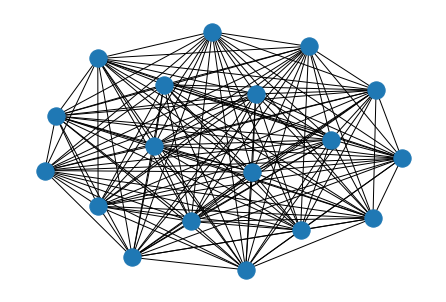

In [4]:
nx.draw(W_G)

In [5]:
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler
import dimod
import dwave.inspector

bqm = dimod.from_networkx_graph(W_G, vartype='BINARY', edge_attribute_name='weight', node_attribute_name='weight')

sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=100, chain_strength=-5.0)

In [6]:
sampleset.record

rec.array([([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], 0., 1, 1.),
           ([1, 1, 1, 1, 0, 1, 1, 0, 1, 

In [7]:
a_s = np.zeros(len(sampleset.record)) 
b_s = np.zeros(len(sampleset.record))

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    mu = 0
    var = 0
    for i in range(states.size):
        if Nodes_category[i] == 'a':
            mu = mu + 2**(Nodes_labels[i%9]) * states[i]
        else:
            var = var + 2**(Nodes_labels[i%9]) * states[i]
            
    a_s[k] = mu
    b_s[k] = var

In [8]:
a_s.mean(), b_s.mean()

(3.88, 2.55234375)

(array([ 6., 13., 10., 25.,  8., 10.,  9., 19.]),
 array([3.75      , 3.78027344, 3.81054688, 3.84082031, 3.87109375,
        3.90136719, 3.93164062, 3.96191406, 3.9921875 ]),
 <BarContainer object of 8 artists>)

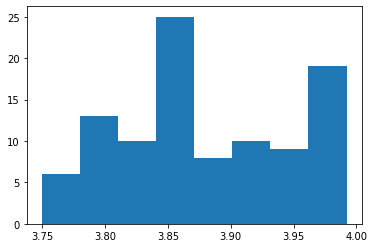

In [9]:
import matplotlib.pyplot as plt

plt.hist(a_s, bins='auto')

(array([27., 22.,  3.,  0.,  0.,  6., 26., 16.]),
 array([1.3203125 , 1.65429688, 1.98828125, 2.32226562, 2.65625   ,
        2.99023438, 3.32421875, 3.65820312, 3.9921875 ]),
 <BarContainer object of 8 artists>)

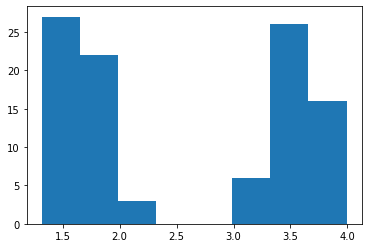

In [10]:
plt.hist(b_s, bins='auto')